# APP

In [4]:
import pickle
from PIL import Image
import numpy as np
from pathlib import Path
from epb_detection_system import preprocess_epb_image, EPBRecognitionSystem, TwoDPCA

In [5]:
# 1. Carrega o modelo
print("📦 Carregando modelo treinado...")
with open('models/epb_recognition_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

system = model_data['system']
target_size = model_data['target_size']

print("   ✓ Modelo carregado com sucesso!")
print()

# 2. Processa todas as imagens do diretório img-teste
img_folder = Path('img-teste')
image_files = sorted(list(img_folder.glob('*.png')) + list(img_folder.glob('*.jpg')) + list(img_folder.glob('*.jpeg')))

if len(image_files) == 0:
    print("⚠️  Nenhuma imagem encontrada no diretório 'img-teste'")
else:
    print("="*70)
    print(f"🔍 PREDIÇÕES PARA {len(image_files)} IMAGENS")
    print("="*70 + "\n")
    
    for img_path in image_files:
        try:
            # Carrega e processa imagem
            img = Image.open(img_path).convert('L')
            img = np.array(img.resize(target_size))
            
            # Pré-processamento simplificado
            img = preprocess_epb_image(img)
            
            # Faz predição
            prob = system.predict_proba(img.reshape(1, *img.shape))[0]
            pred = system.predict(img.reshape(1, *img.shape))[0]
            
            # Exibe resultado
            print(f"📸 {img_path.name}")
            print(f"   EPB detectada: {'SIM' if pred == 1 else 'NÃO'}")
            print(f"   Probabilidade: {prob[1]*100:.2f}%")
            
            # Indicador de confiança
            confidence = max(prob)
            if confidence > 0.9:
                print(f"   Confiança: 🟢 ALTA ({confidence*100:.1f}%)")
            elif confidence > 0.7:
                print(f"   Confiança: 🟡 MÉDIA ({confidence*100:.1f}%)")
            else:
                print(f"   Confiança: 🔴 BAIXA ({confidence*100:.1f}%)")
            print()
            
        except Exception as e:
            print(f"❌ {img_path.name}")
            print(f"   Erro ao processar: {str(e)}")
            print()
    
    print("="*70)
    print("✅ PROCESSAMENTO CONCLUÍDO")
    print("="*70)

📦 Carregando modelo treinado...
   ✓ Modelo carregado com sucesso!

🔍 PREDIÇÕES PARA 2 IMAGENS

📸 O6_BJL_20250723_003008.png
   EPB detectada: NÃO
   Probabilidade: 32.19%
   Confiança: 🔴 BAIXA (67.8%)

📸 O6_CA_20251023_001620.png
   EPB detectada: SIM
   Probabilidade: 93.01%
   Confiança: 🟢 ALTA (93.0%)

✅ PROCESSAMENTO CONCLUÍDO


🔬 ANÁLISE DETALHADA DE FEATURES



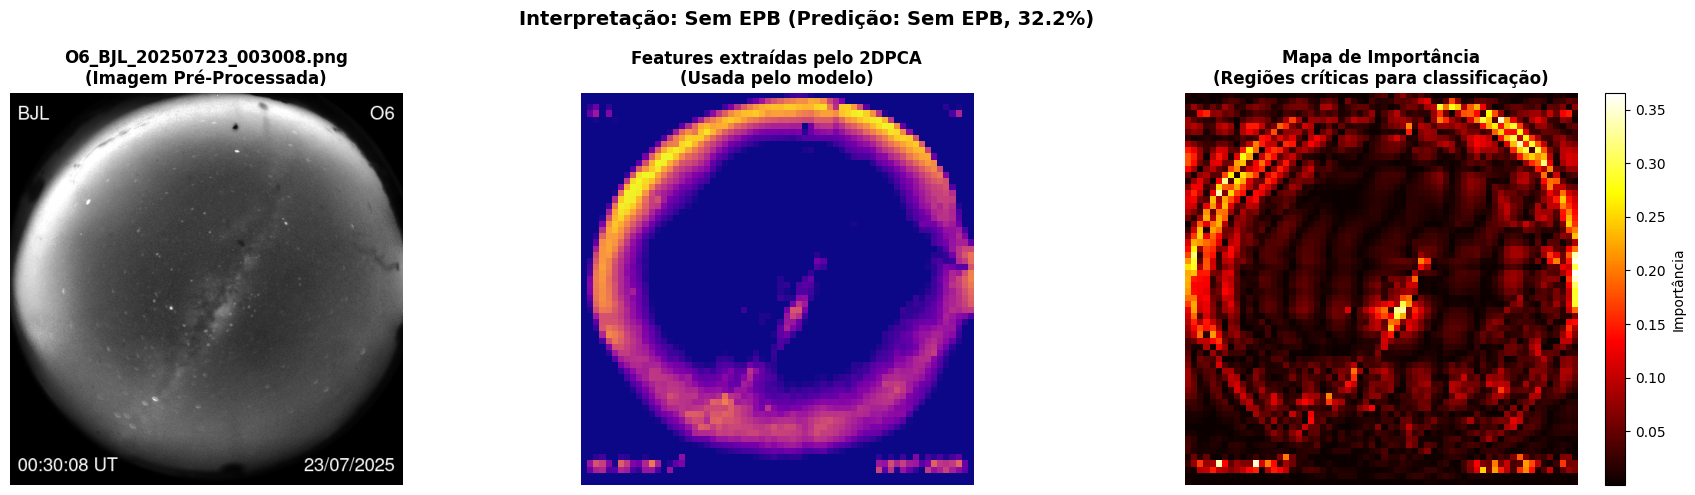

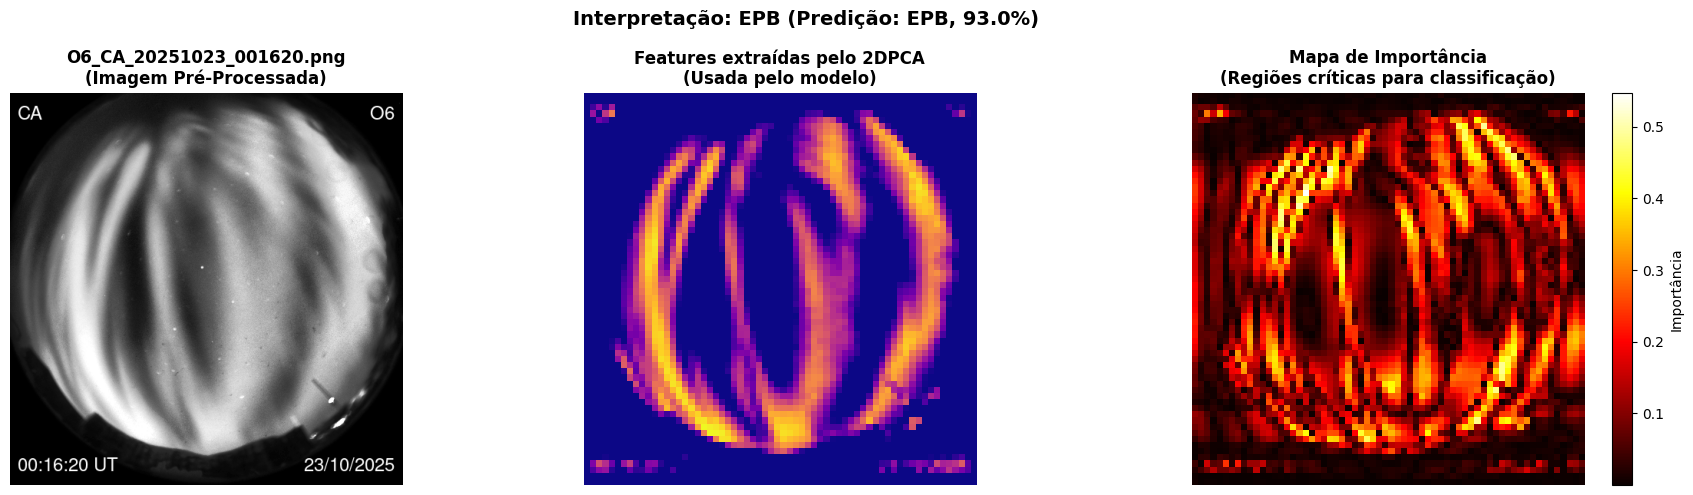

In [8]:
from epb_detection_system import explain_feature_importance_3 as efi

# Imagens específicas para análise detalhada
images = [
    'img-teste/O6_BJL_20250723_003008.png',
    'img-teste/O6_CA_20251023_001620.png'
]

print("="*70)
print("🔬 ANÁLISE DETALHADA DE FEATURES")
print("="*70 + "\n")

for img_path_str in images:
    img_path = Path(img_path_str)
    
    if not img_path.exists():
        print(f"⚠️  Arquivo não encontrado: {img_path}")
        print()
        continue
    
    try:
        # Carrega e processa imagem
        img = Image.open(img_path).convert('L')
        img_original = np.array(img.resize(target_size))
        img_processed = preprocess_epb_image(img_original.copy())
        
        # Faz predição para obter o label predito
        pred = system.predict(img_processed.reshape(1, *img_processed.shape))[0]
        
        # Chama explain_feature_importance
        # Usa pred como y_sample (classe predita) para análise
        importance_map = efi(
            system=system,
            X_sample=img_processed,
            y_sample=pred,  # Usa predição como "classe real" para análise
            filename=img_path.name
        )
    except Exception as e:
        print(f"\n❌ Erro ao analisar {img_path.name}:")
        print(f"   {str(e)}")
        import traceback
        traceback.print_exc()
        print()
